# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3939327412765637412
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9041666487275684989
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 15:25:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    35W / 250W |    375MiB / 16280MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'DenseNet121'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 5
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4"
T_all_labels = "T0", "T1", "T2", "T3", "T4"

#base_path = ''
base_path = 'gdrive/My Drive/Research_5_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_DenseNet121_None S_DenseNet121_imagenet T_DenseNet121_None T_DenseNet121_imagenet


['S_DenseNet121_imagenet',
 'S_DenseNet121_None',
 'T_DenseNet121_imagenet',
 'T_DenseNet121_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2274, 128, 128, 3) (2274, 1)
(758, 128, 128, 3) (758, 1)
(758, 128, 128, 3) (758, 1)

(2034, 128, 128, 3) (2034, 1)
(678, 128, 128, 3) (678, 1)
(678, 128, 128, 3) (678, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2274, 128, 128, 3) (2274, 5)
(758, 128, 128, 3) (758, 5)
(758, 128, 128, 3) (758, 5)

(2034, 128, 128, 3) (2034, 5)
(678, 128, 128, 3) (678, 5)
(678, 128, 128, 3) (678, 5)


## 2-2. Image Check

xTrain_S image Numbers :  2274
xTrain_S image Numbers // 10 :  227
11


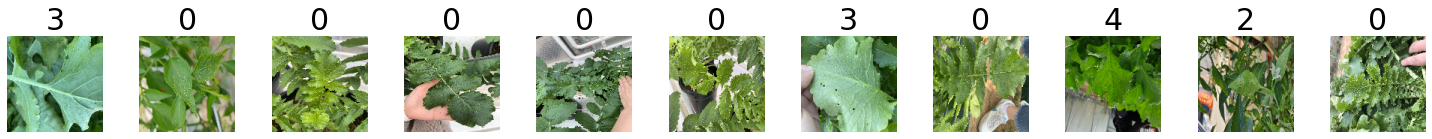

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2034
xTrain_S image Numbers // 10 :  203
11


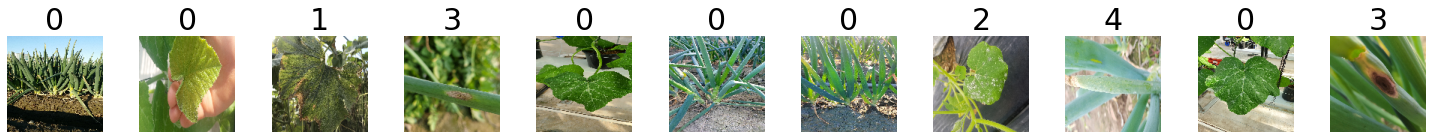

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.DenseNet121 (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.DenseNet121 (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 33s 290ms/step - loss: 0.8983 - accuracy: 0.6456 - val_loss: 1.6807 - val_accuracy: 0.1306
Epoch 2/100
36/36 [==============================] - 6s 162ms/step - loss: 0.6035 - accuracy: 0.7639 - val_loss: 1.7547 - val_accuracy: 0.2586
Epoch 3/100
36/36 [==============================] - 6s 156ms/step - loss: 0.4884 - accuracy: 0.8122 - val_loss: 2.7074 - val_accuracy: 0.1240
Epoch 4/100
36/36 [==============================] - 6s 157ms/step - loss: 0.4695 - accuracy: 0.8219 - val_loss: 3.1948 - val_accuracy: 0.1240
Epoch 5/100
36/36 [==============================] - 6s 156ms/step - loss: 0.4068 - accuracy: 0.8412 - val_loss: 4.6784 - val_accuracy: 0.1240
Epoch 6/100
36/36 [==============================] - 6s 157ms/step - loss: 0.3700 - accuracy: 0.8509 - val_loss: 3.8181 - val_accuracy: 0.1187
Epoch 7/100
36/36 [==============================] - 6s 156ms/step - loss: 0.3268 - accuracy: 0.8663 - val_loss: 2.5254 - val_accuracy: 0.238

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.898349,0.645558,1.680722,0.130607
1,0.603544,0.763852,1.754718,0.258575
2,0.488371,0.812225,2.707360,0.124011
3,0.469485,0.821900,3.194790,0.124011
4,0.406755,0.841249,4.678396,0.124011
...,...,...,...,...
95,0.028870,0.991645,0.831714,0.832454
96,0.012532,0.994723,0.643527,0.883905
97,0.037423,0.990765,1.097435,0.800792
98,0.048710,0.985048,1.803395,0.647757


Minimum validation loss: 0.4478110373020172
Maximum validation accuracy: 0.8839049935340881


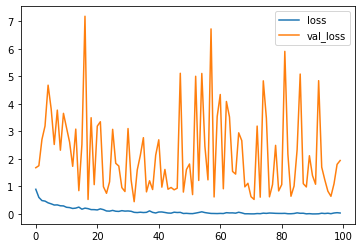

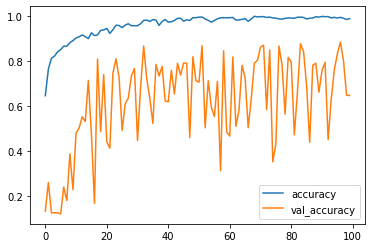

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
24/24 [==============================] - 1s 46ms/step - loss: 1.9358 - accuracy: 0.6280
test loss, test acc: [1.935822606086731, 0.6279683113098145]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

24/24 [==============================] - 3s 31ms/step


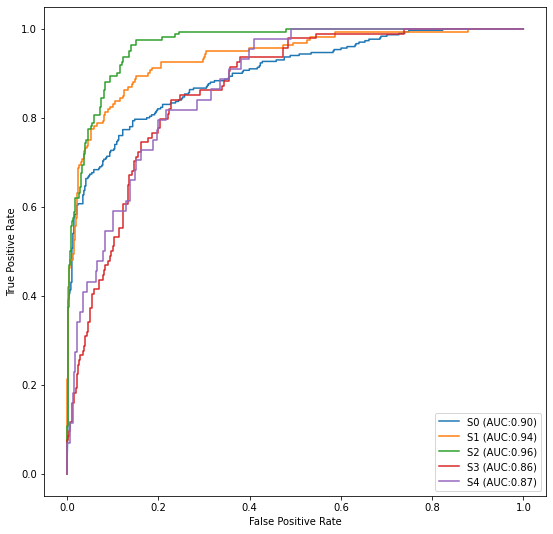

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

29097984/29084464 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 21s 226ms/step - loss: 0.4796 - accuracy: 0.8149 - val_loss: 2.5407 - val_accuracy: 0.4393
Epoch 2/100
36/36 [==============================] - 6s 155ms/step - loss: 0.1965 - accuracy: 0.9160 - val_loss: 5.4599 - val_accuracy: 0.3931
Epoch 3/100
36/36 [==============================] - 6s 161ms/step - loss: 0.1670 - accuracy: 0.9327 - val_loss: 1.7543 - val_accuracy: 0.7493
Epoch 4/100
36/36 [==============================] - 6s 156ms/step - loss: 0.1500 - accuracy: 0.9485 - val_loss: 4.1054 - val_accuracy: 0.5515
Epoch 5/100
36/36 [==============================] - 6s 156ms/step - loss: 0.1447 - accuracy: 0.9516 - val_loss: 3.5324 - val_accuracy: 0.4195
Epoch 6/100
36/36 [==============================] - 6s 157ms/step - loss: 0.1102 - accuracy: 0.9569 - val_loss: 2.2221 - val_accuracy: 0.6161
Epoch 7/100
36/36 [==============================] - 6s 160ms/step - loss: 0.0831 - accuracy: 0.9723 - val_loss: 0.5648 - val_accuracy: 0.860

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.479578,0.814864,2.540743,0.439314
1,0.196504,0.916007,5.459860,0.393140
2,0.166964,0.932718,1.754261,0.749340
3,0.149952,0.948549,4.105433,0.551451
4,0.144713,0.951627,3.532372,0.419525
5,0.110203,0.956904,2.222093,0.616095
6,0.083080,0.972296,0.564774,0.860158
7,0.106633,0.963500,0.953648,0.798153
8,0.053699,0.980211,0.294670,0.931398
9,0.043724,0.987247,0.692278,0.878628


Minimum validation loss: 0.2564374506473541
Maximum validation accuracy: 0.9419525265693665


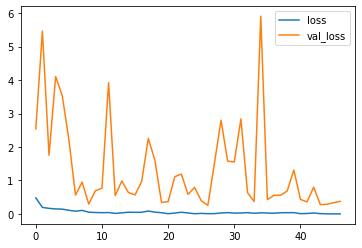

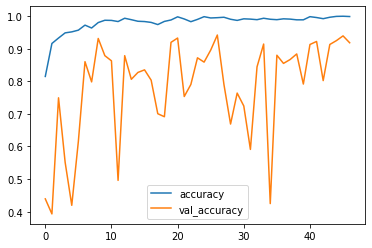

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
24/24 [==============================] - 1s 36ms/step - loss: 0.2617 - accuracy: 0.9393
test loss, test acc: [0.26168909668922424, 0.9393140077590942]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

24/24 [==============================] - 3s 33ms/step


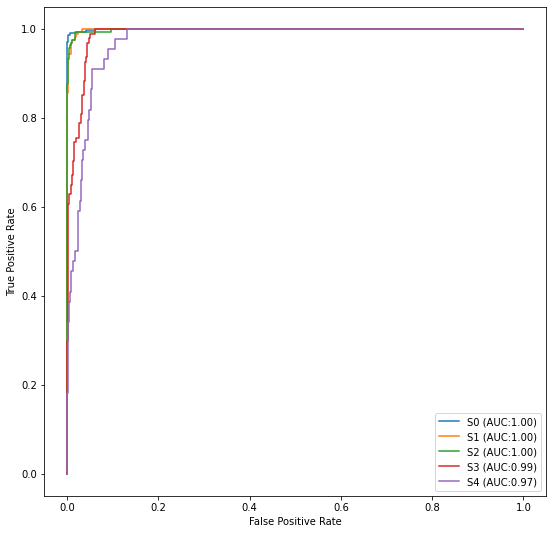

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 23s 284ms/step - loss: 0.7010 - accuracy: 0.7512 - val_loss: 2.0903 - val_accuracy: 0.0811
Epoch 2/100
32/32 [==============================] - 5s 165ms/step - loss: 0.3836 - accuracy: 0.8589 - val_loss: 3.4924 - val_accuracy: 0.1770
Epoch 3/100
32/32 [==============================] - 5s 159ms/step - loss: 0.3227 - accuracy: 0.8835 - val_loss: 3.0415 - val_accuracy: 0.1770
Epoch 4/100
32/32 [==============================] - 5s 160ms/step - loss: 0.2537 - accuracy: 0.9090 - val_loss: 3.5136 - val_accuracy: 0.0664
Epoch 5/100
32/32 [==============================] - 5s 160ms/step - loss: 0.2996 - accuracy: 0.8923 - val_loss: 4.1696 - val_accuracy: 0.1519
Epoch 6/100
32/32 [==============================] - 5s 160ms/step - loss: 0.2280 - accuracy: 0.9125 - val_loss: 4.9931 - val_accuracy: 0.0664
Epoch 7/100
32/32 [==============================] - 5s 159ms/step - loss: 0.2153 - accuracy: 0.9199 - val_loss: 5.4044 - val_accuracy: 0.073

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.700966,0.751229,2.090319,0.081121
1,0.383602,0.858899,3.492422,0.176991
2,0.322696,0.883481,3.041539,0.176991
3,0.253727,0.909046,3.513613,0.066372
4,0.299611,0.892330,4.169564,0.151917
...,...,...,...,...
90,0.014102,0.992625,0.564461,0.873156
91,0.014563,0.996067,1.522406,0.793510
92,0.020890,0.994592,1.556825,0.744838
93,0.006443,0.998525,0.391145,0.915929


Minimum validation loss: 0.1583927720785141
Maximum validation accuracy: 0.9601770043373108


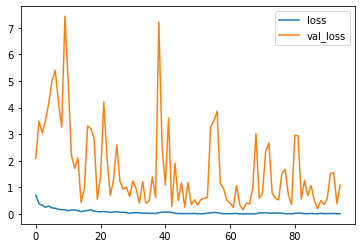

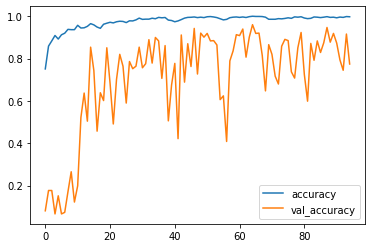

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
22/22 [==============================] - 1s 50ms/step - loss: 0.1559 - accuracy: 0.9661
test loss, test acc: [0.15588603913784027, 0.966076672077179]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

22/22 [==============================] - 3s 35ms/step


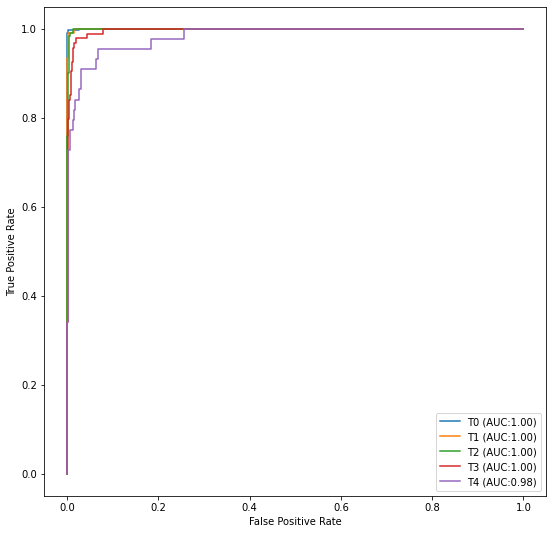

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 22s 244ms/step - loss: 0.3204 - accuracy: 0.8771 - val_loss: 14.8712 - val_accuracy: 0.4469
Epoch 2/100
32/32 [==============================] - 5s 165ms/step - loss: 0.0943 - accuracy: 0.9720 - val_loss: 4.4644 - val_accuracy: 0.5944
Epoch 3/100
32/32 [==============================] - 5s 165ms/step - loss: 0.0830 - accuracy: 0.9784 - val_loss: 8.1900 - val_accuracy: 0.6283
Epoch 4/100
32/32 [==============================] - 5s 165ms/step - loss: 0.0418 - accuracy: 0.9853 - val_loss: 3.0969 - val_accuracy: 0.7257
Epoch 5/100
32/32 [==============================] - 5s 166ms/step - loss: 0.0546 - accuracy: 0.9828 - val_loss: 0.6057 - val_accuracy: 0.8879
Epoch 6/100
32/32 [==============================] - 5s 160ms/step - loss: 0.1108 - accuracy: 0.9656 - val_loss: 12.7815 - val_accuracy: 0.5885
Epoch 7/100
32/32 [==============================] - 5s 160ms/step - loss: 0.0532 - accuracy: 0.9828 - val_loss: 1.0773 - val_accuracy: 0.8

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.320369,0.877090,14.871164,0.446903
1,0.094263,0.971976,4.464389,0.594395
2,0.082986,0.978368,8.190003,0.628319
3,0.041822,0.985251,3.096914,0.725664
4,0.054561,0.982793,0.605730,0.887906
...,...,...,...,...
89,0.005101,0.999017,0.494937,0.887906
90,0.015784,0.995084,0.173641,0.946903
91,0.006296,0.998033,0.084204,0.977876
92,0.007490,0.997542,0.188722,0.961652


Minimum validation loss: 0.04109903797507286
Maximum validation accuracy: 0.99262535572052


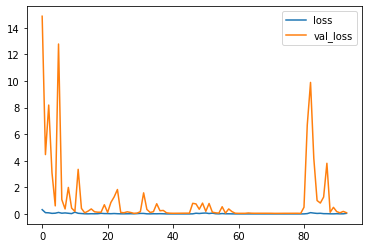

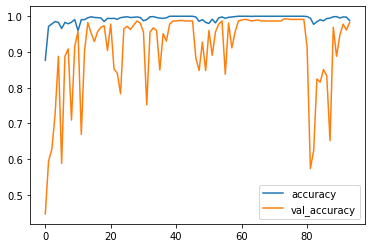

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
22/22 [==============================] - 1s 36ms/step - loss: 0.0398 - accuracy: 0.9867
test loss, test acc: [0.03978009894490242, 0.9867256879806519]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

22/22 [==============================] - 3s 34ms/step


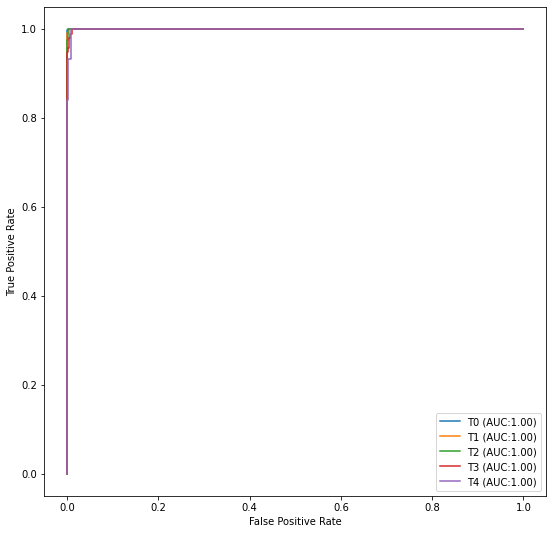

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_DenseNet121_None
test loss, test acc: [1.935822606086731, 0.6279683113098145]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_DenseNet121_imagenet
test loss, test acc: [0.26168909668922424, 0.9393140077590942]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_DenseNet121_None
test loss, test acc: [0.15588603913784027, 0.966076672077179]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_DenseNet121_imagenet
test loss, test acc: [0.03978009894490242, 0.9867256879806519]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_DenseNet121_None →→→ Target Test
22/22 [==============================] - 1s 36ms/step - loss: 5.6597 - accuracy: 0.3510
test loss, test acc: [5.659682750701904, 0.35103243589401245]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_DenseNet121_imagenet →→→ Target Test
22/22 [==============================] - 1s 36ms/step - loss: 4.8950 - accuracy: 0.3953
test loss, test acc: [4.894960880279541, 0.39528024196624756]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_DenseNet121_None →→→ Source Test
24/24 [==============================] - 1s 37ms/step - loss: 5.2371 - accuracy: 0.2639
test loss, test acc: [5.237104892730713, 0.26385223865509033]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_DenseNet121_imagenet →→→ Source Test
24/24 [==============================] - 1s 37ms/step - loss: 5.0749 - accuracy: 0.2625
test loss, test acc: [5.0748772621154785, 0.2625329792499542]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )